In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp 

In [16]:
# Import dataset

data = pd.read_excel('covid_data_input.xlsx', sheet_name = 'data for use')

df = data                                                 # Create dataframe for imported data 


In [17]:
df.head()       # View imported data 

,iso_code,continent,location,date,new_cases_smoothed,new_deaths_smoothed_17day_lag,positive_rate,stringency_index,population_density,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index
0,AUS,Oceania,Australia,2020-10-01,12.857,1.000,0.000,68.06,3.202,0.5,107.791,5.07,83.44,0.939
1,AUT,Europe,Austria,2020-10-01,742.143,7.000,0.040,40.74,106.749,0.7,145.183,6.35,81.54,0.908
2,BGD,Asia,Bangladesh,2020-10-01,1376.429,20.857,0.115,80.09,1265.036,14.8,298.003,8.38,72.59,0.608
3,BEL,Europe,Belgium,2020-10-01,1986.571,32.714,0.054,45.37,375.564,0.2,114.898,4.29,81.63,0.916
4,BOL,South America,Bolivia,2020-10-01,474.429,24.429,0.353,81.48,10.202,7.1,204.299,6.89,71.51,0.693


In [18]:
columns = pd.Index.tolist(df.columns)                                             # View column names (note that new_deaths__smoothed_17_day_lag has double underscore)

var_list = ['intercept']

var_list = var_list + columns

var_list = [v for v in var_list if v not in ('iso_code','continent','location','date','new_deaths_smoothed_17day_lag')]

print(var_list)

['intercept', 'new_cases_smoothed', 'positive_rate', 'stringency_index', 'population_density', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'life_expectancy', 'human_development_index']


In [39]:
i = len(df)                                               # Number of observations in dataset

y = df.new_deaths_smoothed_17day_lag                                      # Outcome variable



# Create Covariate Matrix (X) 

X = df.drop(df.columns[[0,1,2,3,5]], axis = 1)                            # Remove outcome variable to create covariate matrix 


In [40]:
ones = np.ones(i)                                         # Create vector of ones for intercept 
intercept = pd.DataFrame(ones, columns=['intercept'])     # Create dataframe using ones vector

X = intercept.join(X)                                     # Append vector of ones to covariate matrix


j = len(X.columns)                                        # Number of columns in X matrix (max number of coefficients)

X.head()                                                  # View of first few rows of X dataframe 

,intercept,new_cases_smoothed,positive_rate,stringency_index,population_density,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index
0,1.0,12.857,0.000,68.06,3.202,0.5,107.791,5.07,83.44,0.939
1,1.0,742.143,0.040,40.74,106.749,0.7,145.183,6.35,81.54,0.908
2,1.0,1376.429,0.115,80.09,1265.036,14.8,298.003,8.38,72.59,0.608
3,1.0,1986.571,0.054,45.37,375.564,0.2,114.898,4.29,81.63,0.916
4,1.0,474.429,0.353,81.48,10.202,7.1,204.299,6.89,71.51,0.693


In [41]:
print('new_deaths_smoothed_17day_lag','min: ', min(y.round(2)), 'max: ', max(y.round(2)))

print(' ')

for k in var_list:
    print(k, 'min: ', min(X[k].round(2)), 'max: ',max(X[k].round(2)))
    print(' ')

new_deaths_smoothed_17day_lag min:  0.0 max:  813.86
 
intercept min:  1.0 max:  1.0
 
new_cases_smoothed min:  0.0 max:  82866.57
 
positive_rate min:  0.0 max:  0.39
 
stringency_index min:  22.22 max:  87.04
 
population_density min:  3.08 max:  1265.04
 
extreme_poverty min:  0.1 max:  77.6
 
cardiovasc_death_rate min:  86.0 max:  539.85
 
diabetes_prevalence min:  1.82 max:  16.74
 
life_expectancy min:  57.78 max:  83.56
 
human_development_index min:  0.44 max:  0.95
 


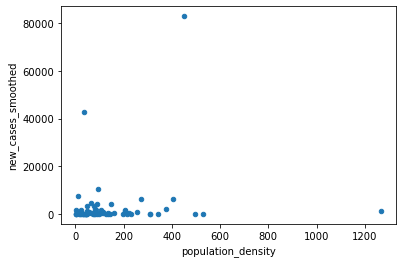

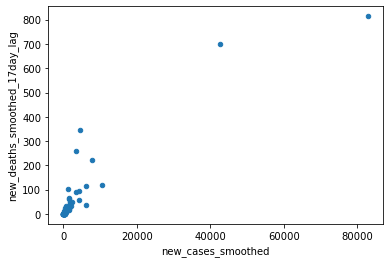

In [42]:
data.plot(x='population_density', y='new_cases_smoothed', kind='scatter')

data.plot(x='new_cases_smoothed', y='new_deaths_smoothed_17day_lag', kind='scatter')
  

In [43]:

data[data['new_cases_smoothed'] > 40000]

#data[data['new_cases_smoothed'] < 50]

#data[data['population_density'] > 1200]

,iso_code,continent,location,date,new_cases_smoothed,new_deaths_smoothed_17day_lag,positive_rate,stringency_index,population_density,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index
22,IND,Asia,India,2020-10-01,82866.571,813.857,0.071,73.61,450.419,21.2,282.280,10.39,69.66,0.640
64,USA,North America,United States,2020-10-01,42691.286,701.714,0.044,62.50,35.608,1.2,151.089,10.79,78.86,0.924


In [44]:
# Rescale variable units to reduce magnitude of coefficients

# Change unit for 'new_deaths_smoothed_17day_lag' to 100 

X2 = X.copy()

# Change unit for 'new_cases_smoothed' to 10

X2['new_cases_smoothed'] = X2['new_cases_smoothed']/100


# Change scale for 'human development index' to 0 to 100 

X2['human_development_index'] = X2['human_development_index']*100

# Change scale for 'positive rate' 

X2['positive_rate'] = X2['positive_rate']*100

# Change scale for 'stringency index' 

X2['stringency_index'] = X2['stringency_index']/100

# Change scale for 'population density' 

X2['population_density'] = X2['population_density']/100

# Change scale for 'extreme poverty' 

X2['extreme_poverty'] = X2['extreme_poverty']/10

# Change scale for 'cardiovascular death rate' 

X2['cardiovasc_death_rate'] = X2['cardiovasc_death_rate']/1000

# Change scale for 'intercept' 

X2['intercept'] = X2['intercept']*10

In [45]:
print('new_deaths_smoothed_17day_lag','min: ', min(y), 'max: ', max(y))

print(' ')

print('Rescaled Covariates')

print(' ')

for k in var_list:
    print(k, 'min: ', min(X[k].round(2)), 'max: ',max(X2[k].round(2)))
    print(' ')

new_deaths_smoothed_17day_lag min:  0.0 max:  813.857
 
Rescaled Covariates
 
intercept min:  1.0 max:  10.0
 
new_cases_smoothed min:  0.0 max:  828.67
 
positive_rate min:  0.0 max:  38.9
 
stringency_index min:  22.22 max:  0.87
 
population_density min:  3.08 max:  12.65
 
extreme_poverty min:  0.1 max:  7.76
 
cardiovasc_death_rate min:  86.0 max:  0.54
 
diabetes_prevalence min:  1.82 max:  16.74
 
life_expectancy min:  57.78 max:  83.56
 
human_development_index min:  0.44 max:  95.3
 


In [52]:

y_array = y.to_numpy()                                     # Convert outcome variable to array for cvxpy optimization

X_array = X2.to_numpy()                                    # Convert X dataframe to a nump array for cvxpy optimization


# Define optimization variables 

z = cp.Variable(j, boolean = True)                                   # z parameters that will select coefficients to include in model 
                                                                     # z takes on values of only 1 and zero 
b = cp.Variable(j)                                                   # beta parameters (coefficient estimates)

# Optimization problem and results 

for k in range(2,j+1):                                               # range starts at 2 since intercept must be included 

    constraint = [b >= z*-15, b <= z*15, z[0] == 1, cp.sum(z) == k]  # constraints for optimization problem

    # Set up minimization problem
    obj = cp.Minimize(cp.sum_squares(X_array @ b - y_array))         # Minimize distance between predicted and actual y
                                                                     # Measure of distance is the L2 norm
    prob = cp.Problem(obj, constraint)                               # Set up optimization problem using objective and constraint

    # Solve the minimization problem 
    sol = prob.solve('ECOS_BB')                                      # Note that solution is obtained using ECOS_BB solver 

    # Output results
    print('Number of beta parameters: ', k)                          # Number of included covariates equals k-1
    
    #print(b.value)
    #print(z.value)
    
    epsilon = 0.00001                                         # Set tolerance for numerical output
    
    # Generate output for estimated beta coeffiecients
    
    betas = pd.DataFrame(b.value,index=var_list)
    betas[np.abs(betas) < epsilon] = 0
    betas = betas.round(decimals=4)
    print(betas)
    
    # Generate output for model selection indicators 
    
    print(' ')
    
    print('Selected covariates:')
    
    selection = pd.DataFrame(z.value,index=var_list)
    selection[np.abs(selection) < epsilon] = 0
    selection = selection.round(decimals=4)
    print(selection)
    
    # Compute R-squared and Adjusted R-Squared
    
    resids = y_array - (X_array @ b.value)
    
    J = np.ones((i,i))
    SSE = np.transpose(resids)@resids
    SSR = np.transpose(b.value)@np.transpose(X_array)@y_array - (1/i)*np.transpose(y_array)@J@y_array
    SST = SSR + SSE
    
    R_sq = SSR/SST
    adj_R = 1 - (SSE/(i-j) )  /   (SST/(i-1))
    
    print(" ")
    
    print('R-squared: ', R_sq.round(decimals=4), 'Adjusted R-squared: ', adj_R.round(decimals=4))
    
    print(" ")

Number of beta parameters:  2
                              0
intercept                1.8568
new_cases_smoothed       1.1251
positive_rate            0.0000
stringency_index         0.0000
population_density       0.0000
extreme_poverty          0.0000
cardiovasc_death_rate    0.0000
diabetes_prevalence      0.0000
life_expectancy          0.0000
human_development_index  0.0000
 
Selected covariates:
                           0
intercept                1.0
new_cases_smoothed       1.0
positive_rate            0.0
stringency_index         0.0
population_density       0.0
extreme_poverty          0.0
cardiovasc_death_rate    0.0
diabetes_prevalence      0.0
life_expectancy          0.0
human_development_index  0.0
 
R-squared:  0.8304 Adjusted R-squared:  0.8045
 
Number of beta parameters:  3
                              0
intercept                0.0268
new_cases_smoothed       1.1184
positive_rate            2.6560
stringency_index         0.0000
population_density       0.0000
ext